# Cilia carpet with local interactions

In [ ]:
# Reload packages when %autoreload is called; doesn't always work?
%load_ext autoreload

In [1]:
%autoreload
# import packages needed below
import time
import os
import pathlib
import numpy as np
import scipy as sp
from scipy.integrate import solve_ivp
import pandas as pd
import scipy.linalg as lin
from scipy.linalg import norm
import scipy.sparse as sparse
import scipy.sparse.linalg as splin
# import plotting routines
%matplotlib inline 
import matplotlib.pyplot as plt

import math
import colorsys

import carpet
import carpet.triangular_lattice as lattice

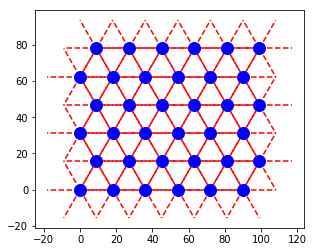

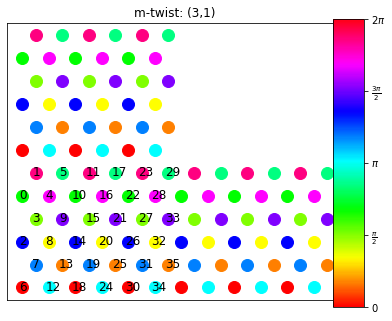

In [15]:
# parameters
set_name = 'machemer_1' # which hydrodynamic coefficients to use
order_g11 = (8,0)
order_g12 = (4,4)
a = 18  # [um] lattice spacing
T = 31.25 # [ms] period of cilia beat
freq = 2 * sp.pi / T # [rad/ms] angular frequency

# periodic boundary conditions: how many copies of the unit cell?
nx = 6  # []
ny = 6  # [] must be even

coords, lattice_ids = lattice.get_nodes_and_ids(nx, ny, a)
N1, T1 = lattice.get_neighbours_list(coords, nx, ny, a)
get_mtwist_phi = lattice.define_get_mtwist(coords, nx, ny, a)

carpet.plot_edges(coords, T1)
carpet.plot_nodes(coords, color='blue')
plt.show()

# Visualize mtwist
k1 = 3  # [] integer
k2 = 1
phi = get_mtwist_phi(k1, k2)
fig, ax = carpet.plot_nodes(coords, phi=phi,colorbar=False)

ax.set_title('m-twist: (' + str(k1) + ',' + str(k2) + ')')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
fig.set_size_inches(6, 8)

# Duplicate
L1,L2 = lattice.get_domain_sizes(nx,ny ,a)
carpet.plot_nodes(coords + sp.array([L1, 0])[sp.newaxis, :], phi=phi, colorbar=False)
carpet.plot_nodes(coords + sp.array([0, L2])[sp.newaxis, :], phi=phi, colorbar=True)
carpet.plot_node_numbers(coords, a, ax=ax)

plt.show()

In [24]:
## 
gmat_glob, q_glob = lattice.define_gmat_glob_and_q_glob(set_name, a, N1, T1,order_g11, order_g12, T)
right_side_of_ODE = lattice.define_right_side_of_ODE(gmat_glob, q_glob)
solve_cycle = carpet.define_solve_cycle(right_side_of_ODE,2 * T, carpet.get_mean_phase)

## Use solve_cycle

In [26]:
phi0 = get_mtwist_phi(1,0)
print("tol\t Time Spent \t Num steps")
phi1s = []
tols = [10 **-10, 10 ** - 8, 10 ** -6, 10 ** -4]
for tol in tols:
    start = time.time() # track CPU time
    solution = solve_cycle(phi0, tol)
    time_spent = time.time() - start
    print("{:.3e}\t{:.3g}\t{:d}".format(tol,time_spent, len(solution.t)))
    phi1s.append(solution.y.T[-1])

tol	 Time Spent 	 Num steps
1.000e-10	33.5	89
1.000e-08	13.5	37
1.000e-06	6.03	17
1.000e-04	4.54	13


## 0.1 Check period

In [28]:
k1 = 0 # [] integer
k2 = 0 
ix_perturbed = 20 # perturb just one cilium
tol = 10 ** -4
delta0 = 0

phi0 = get_mtwist_phi(k1, k2) 
phi0[ix_perturbed] += delta0 # add perturbation

solution = solve_cycle(phi0, tol)
print("Period of a single cilium vs group: {:.3g} {:.3g}.".format(T,solution.t[-1]))

Period of a single cilium vs group: 31.2 29.8.


## 1. CHECK: Scaling of simulation results with amplitude of initial perturbation

In [30]:
## Solve when initial, m-twist solution is perturbed
# m-twist solution
# wave numbers of m-twist solution
k1 = 0 # [] integer
k2 = 0 
ix_perturbed = 20 # perturb just one cilium
tol = 10 ** - 6

delta0s = [10** -4, 2 * 10 **-4, 10 ** -3, 2 * 10 ** -3, 10 **-2, 2 * 10 ** -2, 10 **-1, 2* 10 **-1, 5 * 10 ** -1]
results = []
for delta0 in delta0s:
    phi0 = get_mtwist_phi(k1, k2) 
    phi0[ix_perturbed] += delta0 # add perturbation
    solution = solve_cycle(phi0, tol)
    phi1 = solution.y.T[-1]
    results.append([delta0, solution.t[-1], \
               phi1[ix_perturbed]-phi0[ix_perturbed]-2*sp.pi, \
               phi1[ix_perturbed+1]-phi0[ix_perturbed+1]-2*sp.pi])

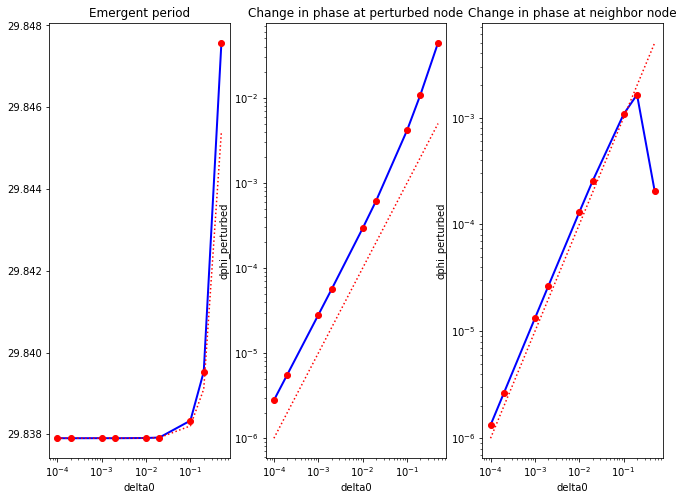

In [31]:
## Plot
delta0_list = np.array(results)[:,0]
T_list = np.array(results)[:,1]
dphi_perturbed = np.array(results)[:,2]
dphi_neighbor = np.array(results)[:,3]

# Plot results
fig = plt.figure()
# ... emergent period
ax = fig.add_subplot(1, 3, 1)
ax.plot(delta0_list, T_list, '.-', color='blue', lw=2, markeredgecolor='red', markerfacecolor='red', markersize=12 )
ax.plot(delta0_list,T_list[0]+0.03*delta0_list**2,'r:') # fitted by eye
ax.set_xscale('log')
ax.set_xlabel('delta0')
# ax.ylabel('T [ms]')
ax.set_title('Emergent period')
# ... change in phase at pertubed node
ax = fig.add_subplot(1, 3, 2)
ax.plot(delta0_list, abs(dphi_perturbed), '.-', color='blue', lw=2, markeredgecolor='red', markerfacecolor='red', markersize=12 )
ax.plot(delta0_list,0.01*delta0_list,'r:')
ax.set_xscale('log')
ax.set_yscale('log')
#ax.set_ylim([1e-6,1e-2])
ax.set_xlabel('delta0')
ax.set_ylabel('dphi_perturbed')
ax.set_title('Change in phase at perturbed node')
# ... change in phase at neighboring node
ax = fig.add_subplot(1, 3, 3)
ax.plot(delta0_list, abs(dphi_neighbor), '.-', color='blue', lw=2, markeredgecolor='red', markerfacecolor='red', markersize=12 )
ax.plot(delta0_list,0.01*delta0_list,'r:')
ax.set_xscale('log')
ax.set_yscale('log')
#ax.set_ylim([1e-6,1e-2])
ax.set_xlabel('delta0')
ax.set_ylabel('dphi_perturbed')
ax.set_title('Change in phase at neighbor node')
fig.set_size_inches(11,8)    
plt.show()